# Random Features Regression Examples

This notebook is useful for debugging random feature implementations by performing simple regressions (e.g. quadratic and sinusoidal). It can be sued to inspect the impact of number of features, parameters etc.

In [14]:
from functools import partial

import numpy as np
import torch 
from matplotlib import pyplot as plt
from pyro.contrib.gp.kernels import Kernel, Exponential, RBF

from gp_sinkhorn.MLE_drift import *
from gp_sinkhorn.RFF import RandomFourierFeatures
from gp_sinkhorn.arccos import ArcCos

### ArcCos kernel random features

In [2]:
# Initialise ArcCos kernel
var_b = 1e4
var_w = 1e4
ac = partial(ArcCos, variance_b=torch.tensor(var_b), variance_w=torch.tensor(var_w))

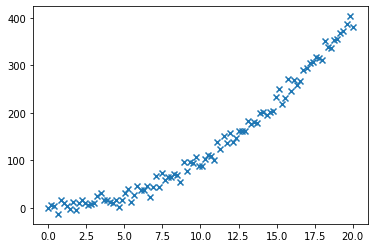

In [3]:
# Generate data for regression problem
np.random.seed(37)
xs = np.linspace(0, 20, 100)
ys = xs ** 2 + np.random.normal(0, 10, size=xs.shape)
plt.scatter(xs, ys, marker="x")

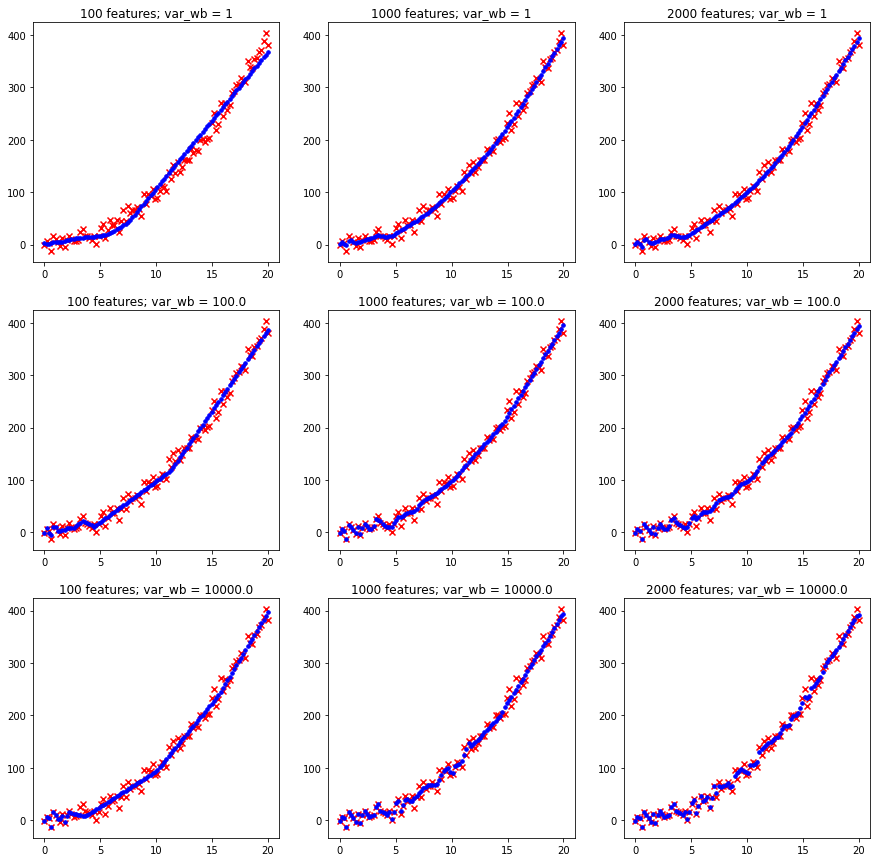

In [4]:
# Compare the fit for a few different parameters
x = torch.tensor(xs[:, None])
y = torch.tensor(ys[:, None])

var_wbs = (1, 1e2, 1e4)
num_featureses = (100, 1000, 2000)

fig, axs = plt.subplots(len(num_featureses), len(var_wbs), figsize=(15, 15))
for i, var_wb in enumerate(var_wbs):
    for j, num_features in enumerate(num_featureses):
        r = RandomFourierFeatures(x, y, num_features=num_features, kernel=ac,
                                  debug_rff=False, noise=1, var_w=var_wb, var_b=var_wb)

        ys_pred = r.drift(x)
        axs[i][j].scatter(xs, ys, marker="x", c="red", label="data")
        axs[i][j].scatter(xs, ys_pred.detach().numpy(), marker=".", c="blue", label="fit", s=50)
        axs[i][j].set_title(f"{num_features} features; var_wb = {var_wb}")

plt.show()

#### Use the exact GP

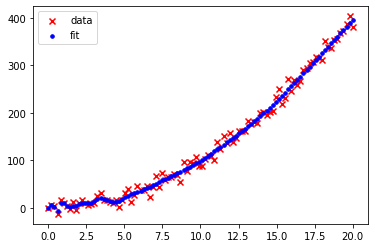

In [5]:
gp_drift_model = MultitaskGPModel(x, y, dt=1, kern=ac, noise=1, 
                                  gp_mean_function=None) 
ys_pred = gp_drift_model.predict(x)
plt.scatter(xs, ys, marker="x", c="red", label="data")
plt.scatter(xs, ys_pred.detach().numpy(), marker=".", c="blue", label="fit", s=50)
plt.legend()

plt.show()

#### Check the kernel approximation error


In [6]:
x = torch.tensor(xs[:, None])
y = torch.tensor(ys[:, None])

r = RandomFourierFeatures(x, y, num_features=5000, kernel=ac,
                          debug_rff=False, noise=1, var_w=1, var_b=1)

exact, approx = r.debug_kernel()

In [7]:
exact

tensor([[   5000.0005,    5004.2705,    5031.9203,  ...,   33769.0895,
           34089.7880,   34410.5032],
        [   5004.2705,    5204.0613,    5411.7846,  ...,   45238.9598,
           45674.6422,   46110.3412],
        [   5031.9203,    5411.7846,    5816.2438,  ...,   59012.2259,
           59586.8796,   60161.5498],
        ...,
        [  33769.0895,   45238.9598,   59012.2259,  ..., 1925008.3504,
         1944802.2510, 1964596.1517],
        [  34089.7880,   45674.6422,   59586.8796,  ..., 1944802.2510,
         1964800.2123, 1984798.1737],
        [  34410.5032,   46110.3412,   60161.5498,  ..., 1964596.1517,
         1984798.1737, 2005000.1958]], dtype=torch.float64,
       grad_fn=<DivBackward0>)

In [8]:
approx

tensor([[   5074.1778,    5062.3034,    5071.4939,  ...,   33354.7617,
           33670.9623,   33987.1670],
        [   5062.3034,    5244.2096,    5435.0455,  ...,   44605.4042,
           45034.3815,   45463.3629],
        [   5071.4939,    5435.0455,    5827.4628,  ...,   58617.2213,
           59187.7365,   59758.2557],
        ...,
        [  33354.7617,   44605.4042,   58617.2213,  ..., 1989547.2646,
         2010027.3057, 2030507.3469],
        [  33670.9623,   45034.3815,   59187.7365,  ..., 2010027.3057,
         2030718.6996, 2051410.0935],
        [  33987.1670,   45463.3629,   59758.2557,  ..., 2030507.3469,
         2051410.0935, 2072312.8401]], dtype=torch.float64,
       grad_fn=<MmBackward0>)

In [9]:
factor = exact / approx
print(round(torch.min(factor).item(), 4), round(torch.max(factor).item(), 4))

0.9675 1.0142


In [10]:
exact / approx

tensor([[0.9854, 0.9885, 0.9922,  ..., 1.0124, 1.0124, 1.0125],
        [0.9885, 0.9923, 0.9957,  ..., 1.0142, 1.0142, 1.0142],
        [0.9922, 0.9957, 0.9981,  ..., 1.0067, 1.0067, 1.0067],
        ...,
        [1.0124, 1.0142, 1.0067,  ..., 0.9676, 0.9676, 0.9675],
        [1.0124, 1.0142, 1.0067,  ..., 0.9676, 0.9675, 0.9675],
        [1.0125, 1.0142, 1.0067,  ..., 0.9675, 0.9675, 0.9675]],
       dtype=torch.float64, grad_fn=<DivBackward0>)

#### A harder example


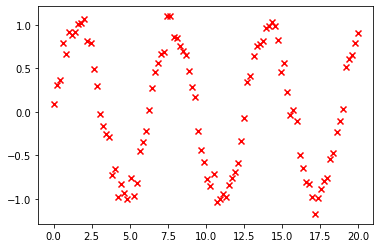

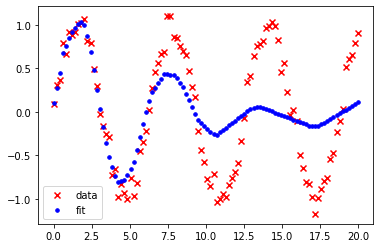

In [11]:
xs = np.linspace(0, 20, 100)
ys = np.sin(xs) + np.random.normal(0, 0.1, size=xs.shape)
xs2 = xs.repeat(2).reshape(len(xs), 2)
plt.scatter(xs, ys, marker="x", c="red")
plt.show()

x = torch.tensor(xs2)
y = torch.tensor(ys[:, None])

r = RandomFourierFeatures(x, y, num_features=1000, noise=1, kernel=ac, debug_rff=False)

ys_pred = r.drift(torch.tensor(xs2))
plt.scatter(xs, ys, marker="x", c="red", label="data")
plt.scatter(xs, ys_pred.detach().numpy(), marker=".", c="blue", label="fit", s=50)
plt.legend()
plt.show()

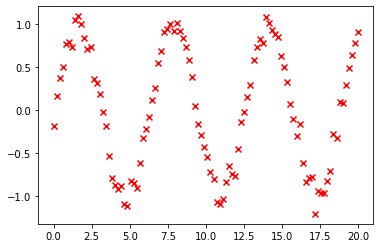

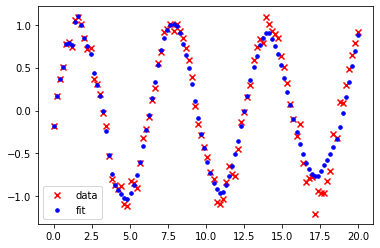

In [12]:
# 1000 features aren't enough... we need many more, and lower noise
xs = np.linspace(0, 20, 100)
ys = np.sin(xs) + np.random.normal(0, 0.1, size=xs.shape)
xs2 = xs.repeat(2).reshape(len(xs), 2)
plt.scatter(xs, ys, marker="x", color="red")
plt.show()

x = torch.tensor(xs2)
y = torch.tensor(ys[:, None])

r = RandomFourierFeatures(x, y, num_features=5000, noise=0.1, kernel=ac, debug_rff=False)

ys_pred = r.drift(torch.tensor(xs2))
plt.scatter(xs, ys, marker="x", c="red", label="data")
plt.scatter(xs, ys_pred.detach().numpy(), marker=".", c="blue", label="fit", s=50)
plt.legend()
plt.show()

### Random Fourier Features

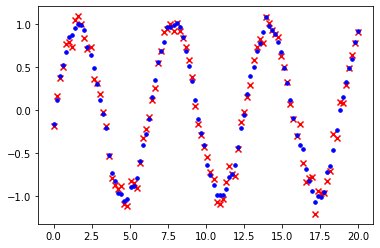

In [17]:
# Try with non-NN kernel features, i.e. Fourier features
x = torch.tensor(xs[:, None])
y = torch.tensor(ys[:, None])

r = RandomFourierFeatures(x, y, num_features=100, debug_rff=False, kernel=Exponential,
                          noise=0, sin_cos=False)

ys_pred = r.drift(x)
plt.scatter(xs, ys, marker="x", c="red", label="data")
plt.scatter(xs, ys_pred.detach().numpy(), marker=".", c="blue", label="fit", s=50)


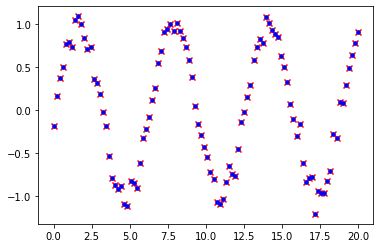

In [18]:
x = torch.tensor(xs[:, None])
y = torch.tensor(ys[:, None])

r = RandomFourierFeatures(x, y, num_features=1000, debug_rff=False, kernel=Exponential,
                          noise=0, sin_cos=True)

ys_pred = r.drift(x)
plt.scatter(xs, ys, marker="x", c="red", label="data")
plt.scatter(xs, ys_pred.detach().numpy(), marker=".", c="blue", label="fit", s=50)


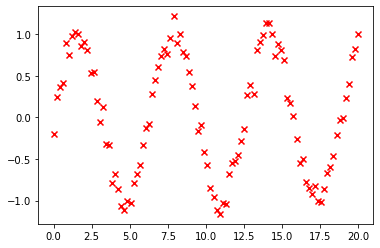

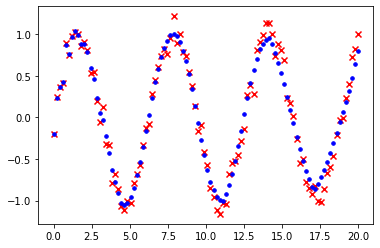

In [20]:
xs = np.linspace(0, 20, 100)
ys = np.sin(xs) + np.random.normal(0, 0.1, size=xs.shape)
xs2 = xs.repeat(2).reshape(len(xs), 2)
plt.scatter(xs, ys, marker="x", c="red")
plt.show()

x = torch.tensor(xs2)
y = torch.tensor(ys[:, None])

r = RandomFourierFeatures(x, y, num_features=5000, noise=.1, kernel=ac, debug_rff=False)

ys_pred = r.drift(torch.tensor(xs2))
plt.scatter(xs, ys, marker="x", c="red", label="data")
plt.scatter(xs, ys_pred.detach().numpy(), marker=".", c="blue", label="fit", s=50)


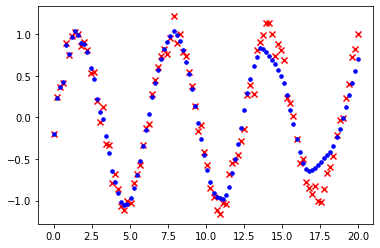

In [22]:
x = torch.tensor(xs2)
y = torch.tensor(ys[:, None])

r = RandomFourierFeatures(x, y, num_features=5000, noise=.1, kernel=ac, debug_rff=False)

ys_pred = r.drift(torch.tensor(xs2))
plt.scatter(xs, ys, marker="x", c="red", label="data")
plt.scatter(xs, ys_pred.detach().numpy(), marker=".", c="blue", label="fit", s=50)
